# Example 2: 2D-3D+3x3x3 network

Download the LCIMB platelet segmentation dataset and train a 2D-3D+3x3x3 net from scratch. See (Guay et al., 2019) for more details.

---

## Setup

In [1]:
import hashlib
import logging
import os
import pickle
import random
import time

import matplotlib.pyplot as plt
import tensorflow as tf

# Utilities for this example, abstracting away a messy in-lab codebase
from src.demos import demo_data, demo_segmentation
from src.download import download_data_if_missing
from src.initialize_instance import initialize_instance
from src.create_network import create_network
from src.train_and_eval import train_and_eval
from src.segment import segment

tf.logging.set_verbosity(tf.logging.ERROR)
logger_level = logging.ERROR

---

## Data download

#### Data download and example output directories

In [2]:
download_dir = os.path.expanduser('~/examples/data')
output_dir = os.path.expanduser('~/examples/example2/output')

#### Download data

If the data already exists in the download folder, the download will be skipped.

In [3]:
download_data_if_missing(download_dir)

# Dir containing train/eval/test images
data_dir = os.path.join(download_dir, 'platelet_data')

Folder platelet_data in /home/matthew/examples/data matches online copy.
Skipping download.


#### Data demo

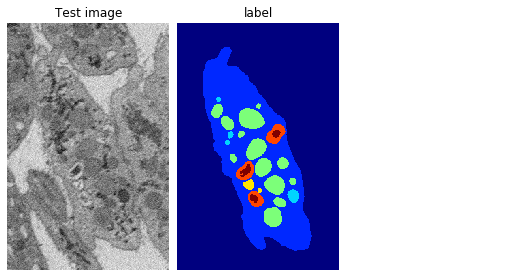

In [4]:
demo_data(data_dir)

---

## Network training

Prep a training run for a 2D-3D+3x3x3 net on the platelet data. The net trains at about 1 it/sec on an NVIDIA GTX 1080, so for this demo we'll only do a few epochs.

### Training settings

In [5]:
# (z, x, y) order
input_shape = (5, 300, 300)

# Number of convolutions per spatial scale in the spatial pyramid
comps_list = (3, 5)

# Number of training epochs
n_epochs = 5

# Number of training iterations between eval runs
n_its_between_evals = 1000

# Early stopping criterion. Specify a metric ('mean_iou' or 'adj_rand_idx')
# a threshold for the metric, and the epoch to begin testing the criterion
stop_criterion = ('mean_iou', 0.3, 10)

# Save directory for this instance of the example
save_dir = os.path.join(output_dir, time.strftime('%m%d'))

# Trainable weight initialization RNG seed
weight_seed = 31415

# Training data presentation order RNG seed
data_seed = 27182

# 3D training windows are taken from a larger 3D volume, which is
# divided up into overlapping training-window-size regions with
# top-left corners spaced (approximately) this far apart:
train_window_spacing = [2, 100, 100]  # (z, x, y) order

# 2D encoder-decoder module settings
net_2d_settings = {
    'spatial_mode': 2,         # 1xkxk convolution and pooling ops
    'pool_z': False,           # don't up/downsample along z axis
    'n_blocks': 3,             # num convolution blocks in the encoder and decoder
    'n_comps': 2,              # num convolutions per block
    'n_kernels': 64,           # num convolution kernels in first encoder block
    'log_gamma2': -4.7,        # log10 of L2 regularization on weights (ignored if < -10)
    'log_gamma1': -11,         # log10 of L1 regularization on weights (ignored if < -10)
    'padding_type': 'same',    # either 'valid' or 'same'. Harder to use 'valid' in 3D
    'pooling_type': 'maxpool'  # either 'maxpool' or 'conv'. Original U-Net used maxpool
}

# 2D predictor module settings
predictor_2d_settings = {
    'spatial_mode': 2,  # same as the 2D encoder-decoder
    'log_gamma2': -9,   # log10 of L2 regularization on weights
    'log_gamma1': -11   # log10 of L1 regularization on weights
}

# 3D spatial pyramid module settings
net_3d_settings = {
    'spatial_mode': 1,       # fully-3D ops
    'padding_type': 'same',  # either 'valid' or 'same'. Harder to use 'valid' in 3D
    'n_kernels': 64,         # num convolution kernels in first encoder block
    'log_gamma2': -5,        # log10 of L2 regularization on weights
    'log_gamma1': -11        # log10 of L1 regularization on weights
}

# 3D predictor module settings
predictor_3d_settings = {
    'spatial_mode': 1,  # same as the 3D spatial pyramid
    'log_gamma2': -9,   # log10 of L2 regularization on weights
    'log_gamma1': -11   # log10 of L1 regularization on weights
}

# Optimization settings (ADAM optimizer: https://arxiv.org/pdf/1412.6980.pdf)
optim_settings = {
    'c_lr_2d': 0.33,              # 2D prediction loss learning rate multiplier      
    'log_learning_rate': -3.,     # log10 of learning rate
    'log_alpha1': -1.5,           # log10 of alpha1 := 1 - beta1
    'log_alpha2': -2.1,           # log10 of alpha2 := 1 - beta2
    'log_epsilon': -7.,           # log10 of epsilon
    'weight_floor': 0.01,         # minimum weight value for weighted cross-entropy loss
    'exponential_decay_rate': 1,  # exponential decay applied to learning rate
    'log_decay_steps': 10         # log10 of exponential decay step count
}

In [6]:
# Define for saving settings during archival
instance_settings = {
    'data_dir': data_dir,
    'instance_dir': None,  # Defined in `initialize_instance()`
    'input_shape': input_shape,
    'comps_list': comps_list,
    'n_epochs': n_epochs,
    'n_its_between_evals': n_its_between_evals,
    'stop_criterion': stop_criterion,
    'weight_seed': weight_seed,
    'data_seed': data_seed,
    'train_window_spacing': train_window_spacing,
    'net_2d_settings': net_2d_settings,
    'predictor_2d_settings': predictor_2d_settings,
    'net_3d_settings': net_3d_settings,
    'predictor_3d_settings': predictor_3d_settings,
    'optim_settings': optim_settings
}

### Initialization

Create a folder within `save_dir` for the output of this instance's run, and archive
all example source code. 

In [7]:
# Updates key 'instance_dir' in `instance_settings`, containing the directory within `save_dir`
# where this example instance's output will be saved
instance_settings, logger = initialize_instance(save_dir, instance_settings, logger_level)

### Network creation

Create a network object - a wrapper around a TensorFlow computation graph that
implements training, evaluation, and inference with a U-Net - as well as
settings dicts for the training and evaluation processes.

In [8]:
net, train_settings, eval_settings = create_network(instance_settings)

### Network training and evaluation

In [9]:
# Return the trained network
net = train_and_eval(net, train_settings, eval_settings, logger)

---

## Segmentation with a trained network

#### Using a net to segment an image

In [10]:
# Set to something to save segmentation images to disk there
output_dir = None

test_seg, test_probs = segment(
    net_sources=net,
    image_source=os.path.join(data_dir, 'test-images.tif'),
    label_source=os.path.join(data_dir, 'test-labels.tif'),
    output_dir=output_dir)

#### Visualizing that segmentation

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(400/110, 609/110))

ax.imshow(test_seg[75], cmap='jet', vmin=0, vmax=6)
ax.set_title('Test prediction')
h = ax.axis('off')

#### Demo of network segmentation on train and eval data

Comparisons with ground truth labels, along with visualizations of the inference probability maps for each class

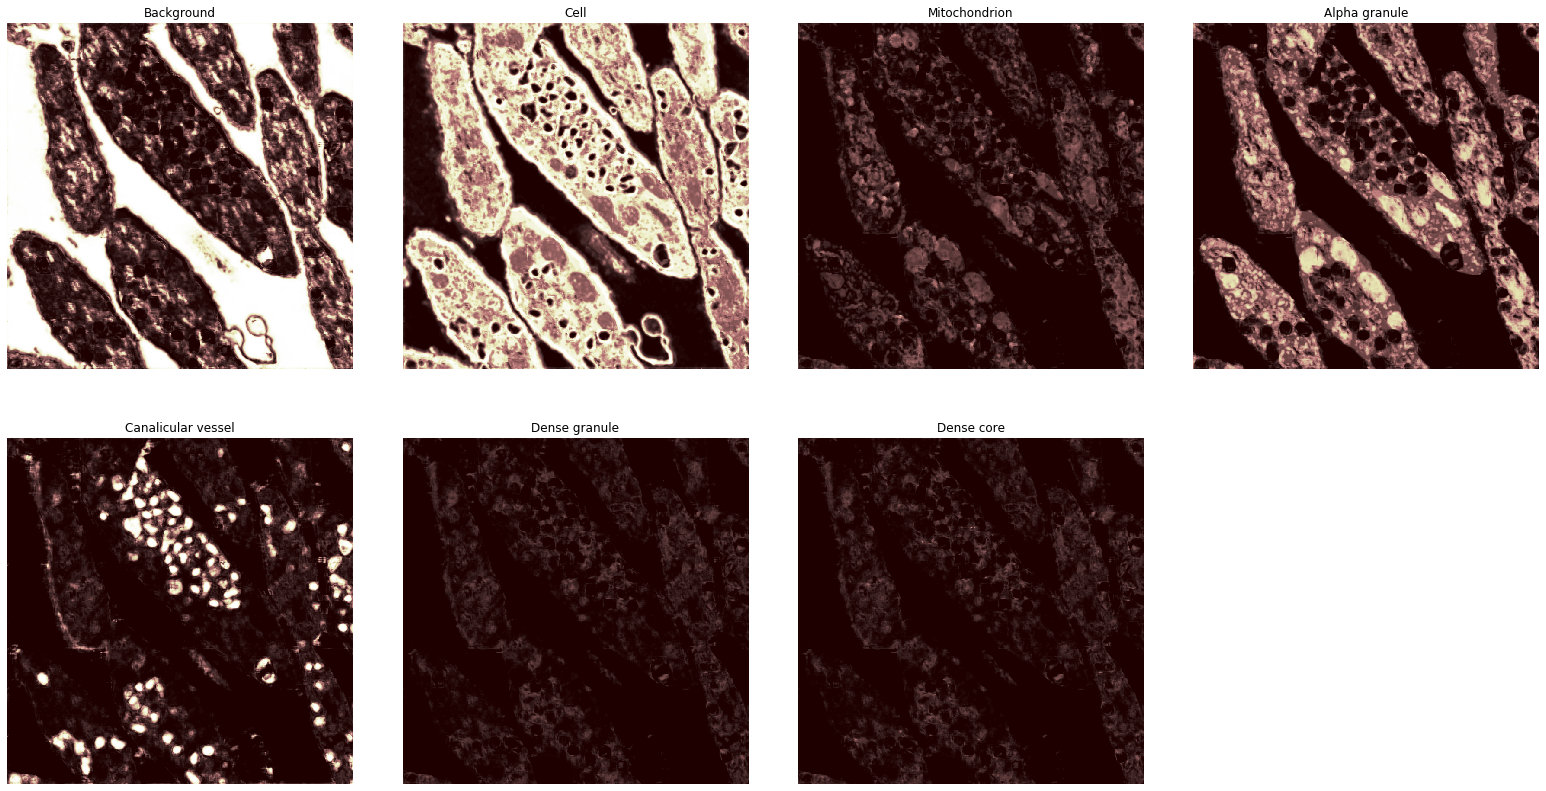

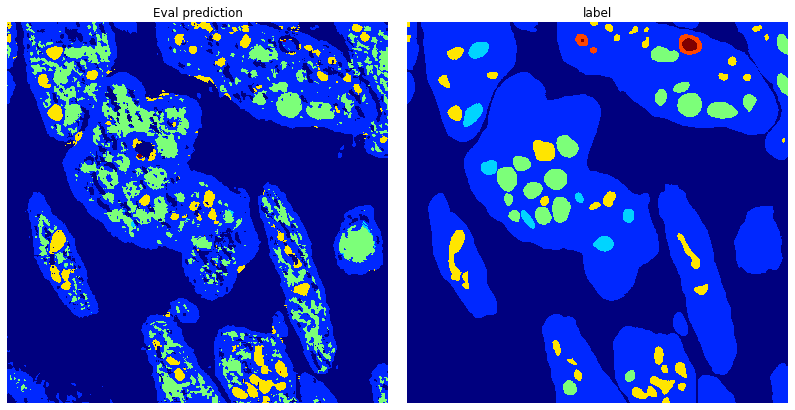

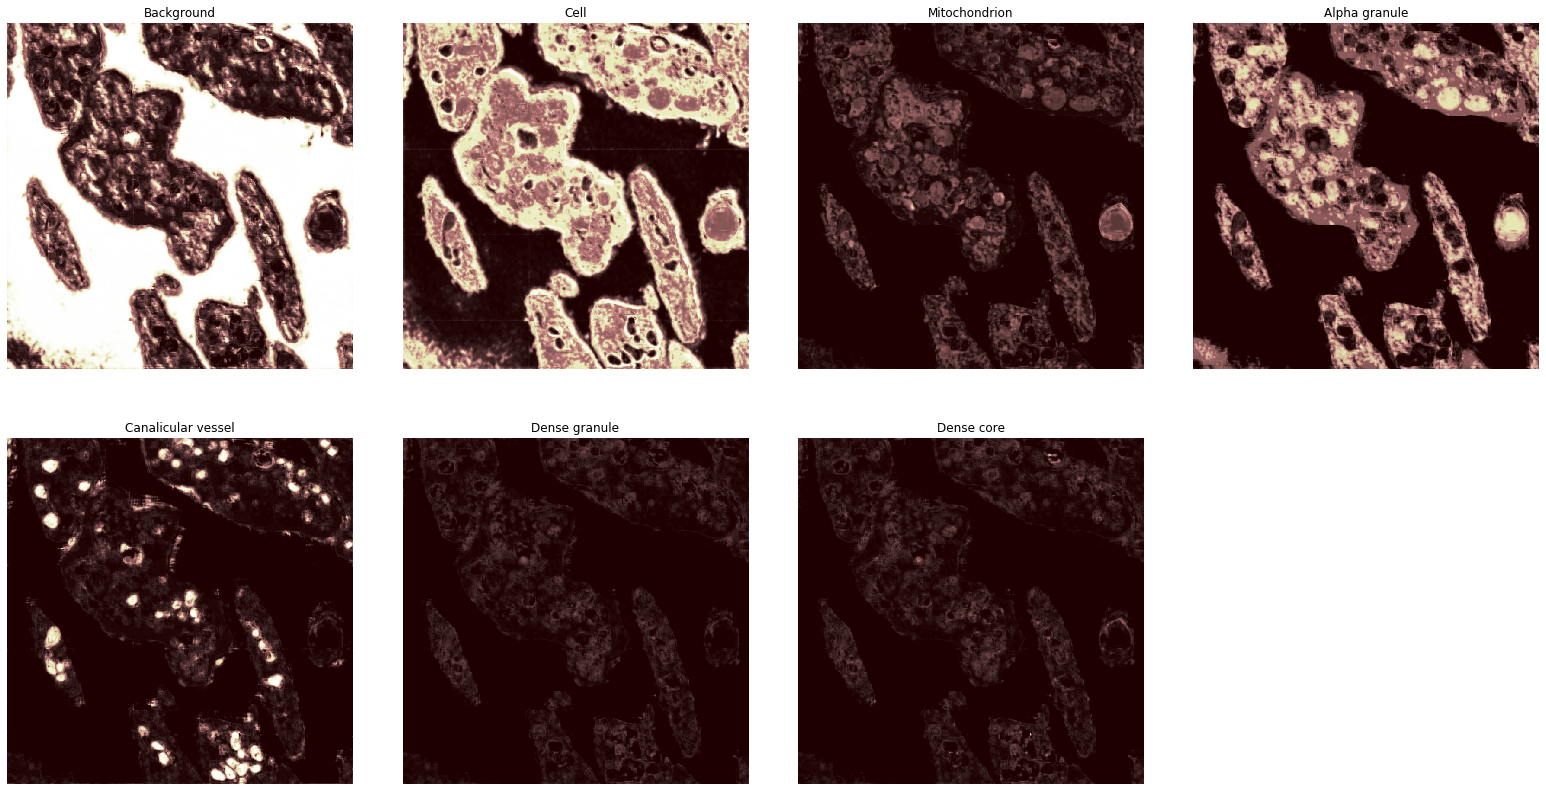

In [12]:
demo_segmentation(net, data_dir)